In [1]:
import configparser
config = configparser.ConfigParser()
config.read("config.properties")

APIKey = config.get("AzureCredentials","APIKey").strip()
Endpoint = config.get("AzureCredentials","Endpoint").strip()
Deployment = config.get("AzureCredentials","Deployment").strip()
version = config.get("AzureCredentials","version").strip()

Googlekey = config.get('GoogleCred','key')


In [52]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(temperature = 0.2,
                                deployment_name=Deployment,
                                openai_api_version=version,
                                openai_api_key=APIKey, 
                                azure_endpoint=Endpoint)
llm.invoke("Hi")



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-7ff0c13d-242c-4421-91d1-9974bce562b6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [1]:
from langchain_aws import ChatBedrock
import boto3
import requests
# boto3.setup_default_session(
#     **requests.get("http://localhost:8000/awscred").json()    
# )

client = ""
llm = ""
def renew():
  global llm
  global client
  boto3.setup_default_session(
      **requests.get("http://localhost:8000/awscred").json()
  )
  client = boto3.client(service_name="bedrock-runtime",region_name="us-east-1")
  llm = ChatBedrock(model_id ="anthropic.claude-3-5-sonnet-20240620-v1:0",
                  client = client,
                  model_kwargs={"max_tokens":5000}
                  #   guardrails={"id": "xpqvrjzg8jpl", "version": "5"}
                  )
renew()
print(llm.invoke("HI , i am facing issue i this azure"))


content="I'm sorry to hear you're experiencing an issue with Azure. To better assist you, I'll need more information about the specific problem you're facing. Could you please provide more details about:\n\n1. What specific Azure service or feature are you using?\n2. What exactly is the issue you're encountering?\n3. Are you seeing any error messages? If so, what do they say?\n4. What steps have you already taken to try to resolve the issue?\n\nThe more information you can provide, the better I'll be able to help you or guide you towards a solution." additional_kwargs={'usage': {'prompt_tokens': 17, 'completion_tokens': 126, 'total_tokens': 143}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} response_metadata={'usage': {'prompt_tokens': 17, 'completion_tokens': 126, 'total_tokens': 143}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} id='run-99912ef6-588e-4196-8228-27aeeaa491e0-0' usage_metadata={'input_tokens':

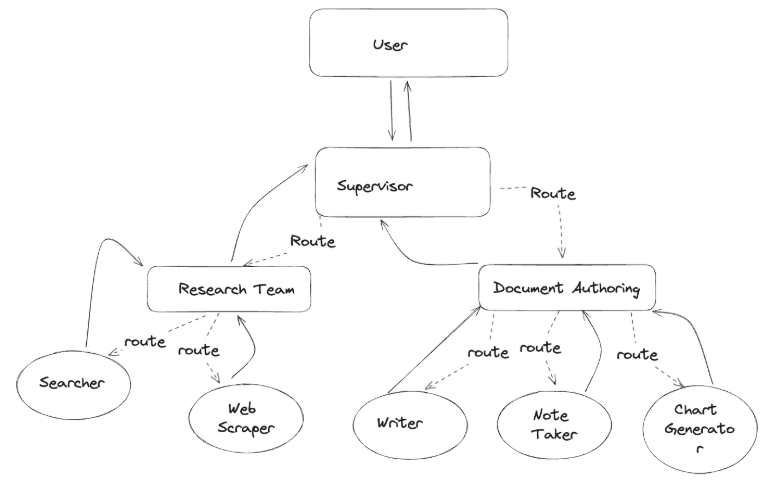

In [5]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [53]:
from langchain_core.tools import tool
from langchain_community.document_transformers import Html2TextTransformer
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.utilities import GoogleSearchAPIWrapper
from duckduckgo_search import DDGS
import os

os.environ["GOOGLE_CSE_ID"] = config.get('GoogleCred','GOOGLE_CSE_ID')
os.environ["GOOGLE_API_KEY"] = config.get('GoogleCred','GOOGLE_API_KEY')

html2text = Html2TextTransformer()
from langchain_core.tools import Tool

def scrapeFromURLs(URLs):
    if isinstance(URLs,str):
        URLs = [URLs]
    loader = AsyncHtmlLoader(URLs,ignore_load_errors=True)
    docs = loader.load() 
    docs_transformed = html2text.transform_documents(docs)
    return docs_transformed


search = GoogleSearchAPIWrapper()
def TopGoogleResult(query):
    return search.results(query, 10)

# ______________________________________________________ DuckDuckGO
def top5_it_results(query):
    results = DDGS().text(query, max_results=10)
    return results

Gtool = Tool(
        name="Google Search Snippets",
        description="Search Google for problem's solution.",
        func=TopGoogleResult,
    )

def refactor(Docs):
    try:
        if isinstance(Docs,str):
            Docs = [Docs]
        _refactorList = []
        for doc in Docs:
            WebTemplate = f"""You are Advance refactor for web scrapped text and you give the most relevant information from the messy document ,here is the new web Ducument:'{doc}' , please provide only the relevant answer within 80 words for user question only ,response:"""
            _refactorList.append(llm.invoke(WebTemplate).content.replace('{','}').replace('}','{'))
        return _refactorList
    except Exception as e:
        print("Azure interuption.....")
        return [f"The website contains in appropriate data so it was filtered,guradrail interuption "]


def search_web(search_query):
    '''A websearch tool which search into web and accepts a web search query'''
    try:
        webpages_to_include = 3

        # structured_llm = llm.with_structured_output(SearchQuery)
        # search_query = structured_llm.invoke([search_instructions]+state['messages']).search_query
        
        Gresult = Gtool.run(search_query)
        Dtool = Tool(
            name="Google Search Snippets",
            description="Search Google for problem's solution.",
            func=top5_it_results,
        )
        # Dresult = Dtool.run(user_text) 

        allResult = Gresult #+ Dresult 
        web_URL = [website.get("link",website.get("href")) for website in allResult]
        web_URL =list(set(web_URL))
        idx = 0 
        document_list = []
        for _, URL in enumerate(web_URL):
            try:
                # WebPageData = refactor(scrapeFromURLs(URL))
                WebPageData = scrapeFromURLs(URL)
                document_list.append(
                    f"""URL:{URL} <document>{WebPageData} </documenet>"""
                )
                if WebPageData[0] in ['' ,None]:
                    continue
            except Exception as e :
                print(f"Skipping..........{e}")
                continue
            idx = idx + 1
            if webpages_to_include == idx:
                break
        print(document_list)
        return {"context": ["\n\n---\n\n".join(document_list)]} 
    except Exception as e:
        print(e)



In [54]:
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [55]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

In [56]:
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

In [57]:
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

In [58]:
@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [59]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [60]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

In [62]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto)

    return supervisor_node

In [63]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

search_agent = create_react_agent(llm, tools=[search_web])

In [16]:
def search_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [18]:
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [19]:

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [29]:
from langgraph.checkpoint.memory import MemorySaver

research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")


memory = MemorySaver()
research_graph = research_builder.compile(checkpointer=memory)

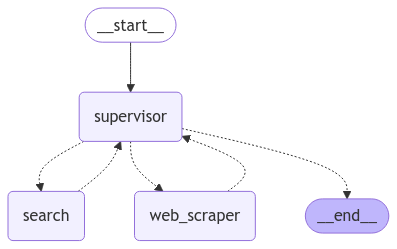

In [30]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [31]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 10,"thread_id": 1}
):
    print(s)
    print("---")

{'supervisor': None}
---


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  5.81it/s]


['URL:https://x.com/taylorswift13/status/1587420273325838336?lang=en <document>[Document(metadata={\'source\': \'https://x.com/taylorswift13/status/1587420273325838336?lang=en\', \'title\': \'Internet Security by Zscaler\', \'description\': \'Zscaler makes the internet safe for businesses by protecting their employees from malware, viruses, and other security threats.\', \'language\': \'No language found.\'}, page_content="---  \\n  \\nD22 |  __Sorry, you don\'t have permission to visit this site.  \\n---  \\n  \\n* * *  \\n  \\n**You have tried to access a web page which is in violation of the Capgemini\\nInternet Security Policy and has been blocked by Contextual Access (provided\\nby Zscaler).**  \\nNot allowed to browse **Social Networking** category  \\nYou tried to\\nvisit:https://x.com/taylorswift13/status/1587420273325838336?lang=en  \\n  \\n* * *  \\n  \\nIf you feel this page has been blocked in error or you have business\\njustification for using it, please complete the prem

# Documentation

In [36]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


In [37]:
def doc_writing_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [38]:
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


In [39]:
def note_taking_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [40]:
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

In [41]:
def chart_generating_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [42]:
# Create the graph here
paper_writing_builder = StateGraph(MessagesState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

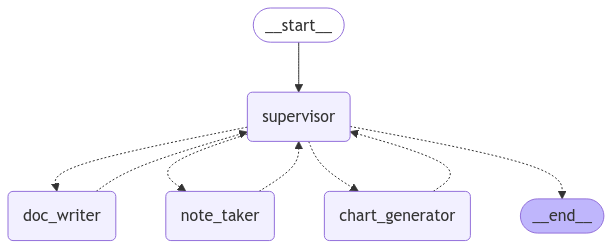

In [43]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [44]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': None}
---
{'note_taker': {'messages': [HumanMessage(content='Great! I\'ve created an outline for a poem about cats and saved it to a file named "cat_poem_outline.txt". Now, I\'ll write the poem based on this outline. Since there isn\'t a specific function to write a poem to disk, I\'ll provide the poem here, and you can save it to a file using your preferred method.\n\nHere\'s the poem based on the outline:\n\nFeline Fascination\n\nIn shadows and sunlight, they prowl with grace,\nEnigmatic creatures of the feline race.\nLithe bodies in motion, a sight to behold,\nTheir agility and balance, a story untold.\n\nIndependent spirits, wrapped in fur so fine,\nMysterious eyes that seem to shine.\nAloof one moment, affectionate the next,\nTheir mercurial nature leaves us perplexed.\n\nCurled up in slumber, soft purrs fill the air,\nThen suddenly alert, with a watchful stare.\nPouncing on toys with childlike glee,\nOr perched by windows, the world to see.\n\nCompanions in silence

In [45]:
from langchain_core.messages import BaseMessage

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [64]:
def call_research_team(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


In [65]:
super_builder = StateGraph(MessagesState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

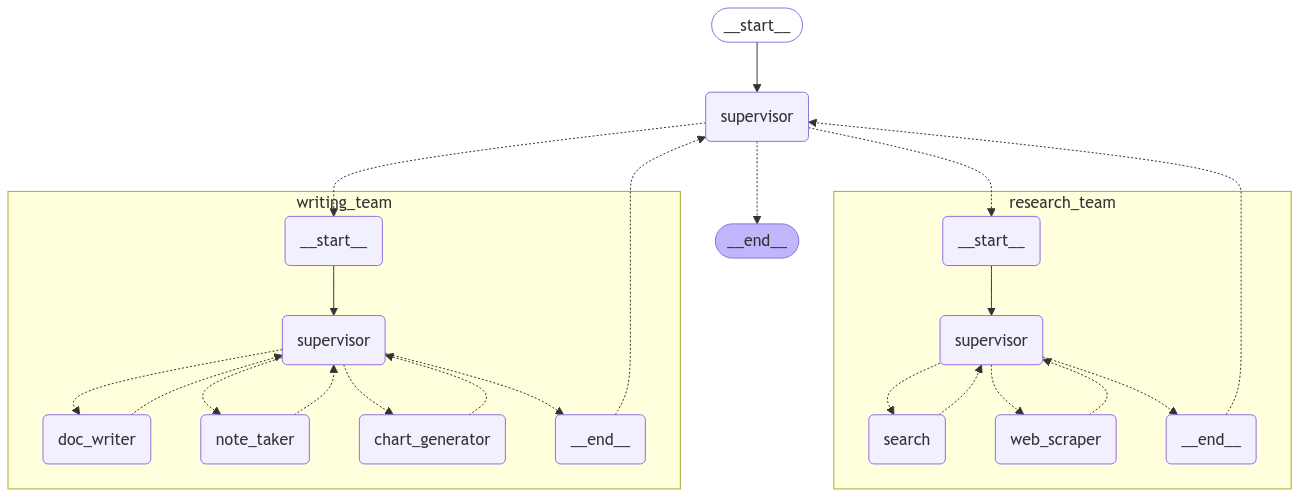

In [66]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(xray=1).draw_mermaid_png()))

In [67]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", " write a brief report about `Research AI agents`")
        ],
    },
    {"recursion_limit": 15},
):
    print(s)
    print("---")

{'supervisor': None}
---


Fetching pages: 100%|##########| 1/1 [00:02<00:00,  2.73s/it]


['URL:https://www.alignmentforum.org/posts/6cWgaaxWqGYwJs3vj/a-basic-systems-architecture-for-ai-agents-that-do <document>[Document(metadata={\'source\': \'https://www.alignmentforum.org/posts/6cWgaaxWqGYwJs3vj/a-basic-systems-architecture-for-ai-agents-that-do\', \'title\': \'A basic systems architecture for AI agents that do autonomous research — AI Alignment Forum\', \'description\': \'A lot of threat models describing how AIs might escape our control (e.g. self-exfiltration, hacking the datacenter) start out with AIs that are actin…\', \'language\': \'en\'}, page_content="This website requires javascript to properly function. Consider activating\\njavascript to get access to all site functionality.\\n\\n##\\n\\nAI ALIGNMENT FORUM\\n\\nAF\\n\\nLogin\\n\\nRedwood ResearchAI\\n\\nCurated\\n\\n2024 Top Fifty: 12%\\n\\n# 71\\n\\n# A basic systems architecture for AI agents that do autonomous research\\n\\nby Buck Shlegeris\\n\\n23rd Sep 2024\\n\\n9 min read\\n\\n15\\n\\n# 71\\n\\nA lot 